# Tusya Detection. Object Recognition.

## Installing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
import time
import os

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold
from skimage.feature import hog

import PIL
import cv2

sns.set_theme(palette='pastel')
plt.rcParams["axes.grid"] = False

## Loading the Dataset

In [2]:
def load_images_from_folder(path):
    images = []
    for img_name in os.listdir(path):
        img = np.array(PIL.Image.open(path+img_name))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, MIN_SIZE)
        images.append(img)
    return images

In [3]:
def load_image(path):
    return np.array(PIL.Image.open(path))

In [4]:
def get_hog(img, block_norm = 'L2-Hys', visualize=False):
    
    if visualize:
        img_features, visual = hog(img, pixels_per_cell = PIXELS_PER_CELL,
                                   cells_per_block = CELLS_PER_BLOCK,
                                   block_norm = block_norm,
                                   visualize = True)
        return img_features, visual

    else:
        img_features = hog(img, pixels_per_cell = PIXELS_PER_CELL,
                           cells_per_block = CELLS_PER_BLOCK,
                           block_norm = block_norm)
    
    return img_features

While I was taking the pictures, I noticed that Tusya's head can ideally be fitted in a square. 

In [5]:
path1 = 'PositiveTusyaHead/'
path2 = 'NegativeTusya/'
MIN_SIZE = (150,150)

PIXELS_PER_CELL = (15,15)
CELLS_PER_BLOCK = (3,3)

In [6]:
positive_tusya = load_images_from_folder(path1)
negative_tusya = load_images_from_folder(path2)
print('Positive dataset shape:', len(positive_tusya))
print('Negative dataset shape:', len(negative_tusya))

Positive dataset shape: 96
Negative dataset shape: 432


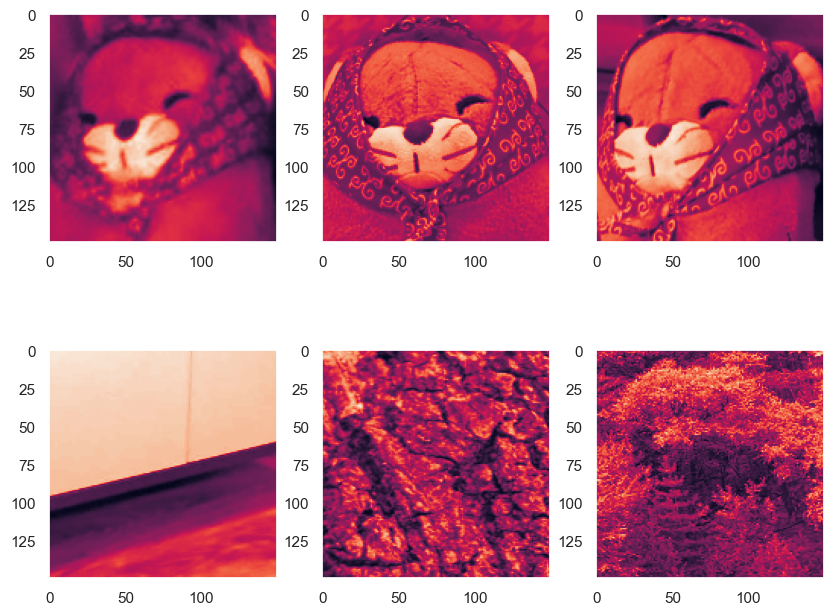

In [7]:
ncols = 3
fig, axs = plt.subplots(2,ncols, figsize=(10,8))
for i in range(3):
    axs[0, i].imshow(positive_tusya[random.choice(range(len(positive_tusya)))])
    axs[1, i].imshow(negative_tusya[random.choice(range(len(negative_tusya)))])

## Histogram of Oriented Gradients (HOG)

In [8]:
pos_features = np.array([get_hog(x) for x in positive_tusya])
neg_features = np.array([get_hog(x) for x in negative_tusya])
pos_labels = np.ones(pos_features.shape[0])
neg_labels = np.zeros(neg_features.shape[0])

X = np.concatenate([pos_features, neg_features])
y = np.concatenate([pos_labels, neg_labels])

print('Shape of Positives:', pos_features.shape)
print('Shape of Negatives:', neg_features.shape)
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of Positives: (96, 5184)
Shape of Negatives: (432, 5184)
Shape of X: (528, 5184)
Shape of y: (528,)


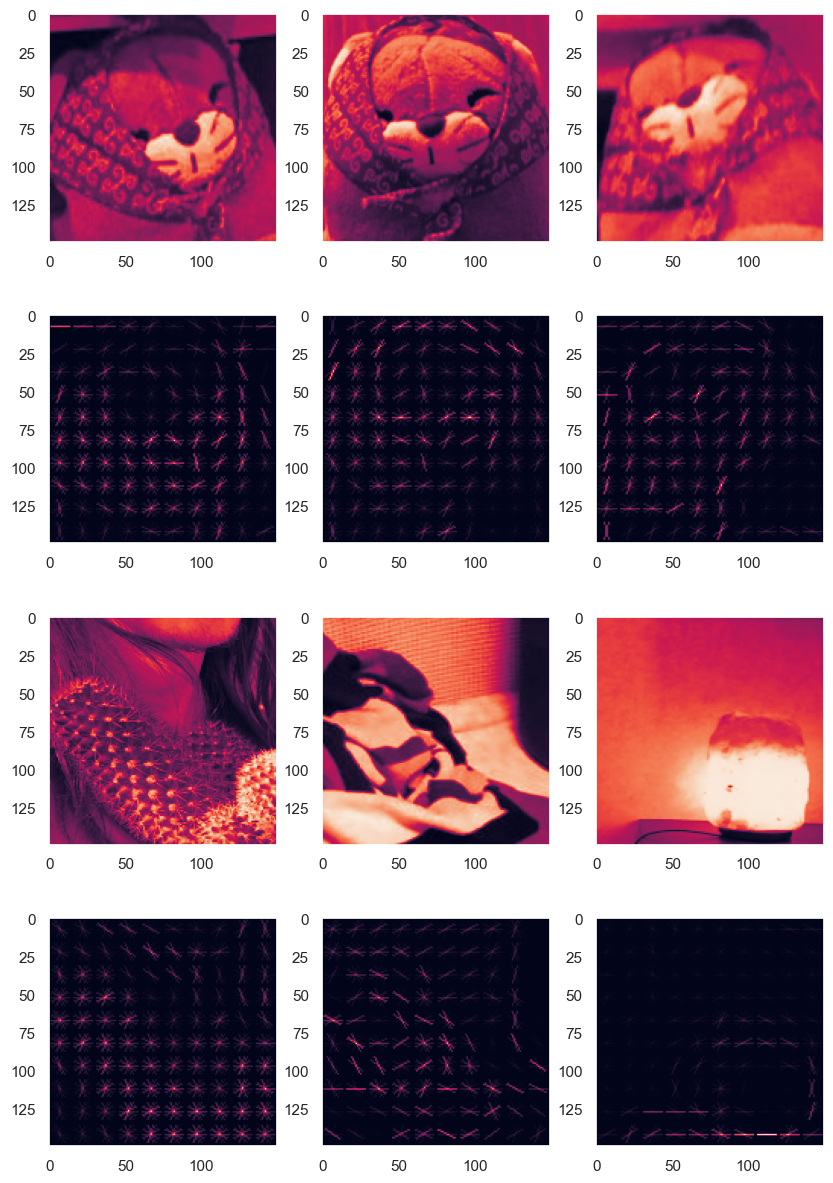

In [9]:
ncols = 3
fig, axs = plt.subplots(4, ncols, figsize=(10,15))
for j in range(ncols):
    sample_index = random.choice(range(len(positive_tusya)-1))
    _, visual = get_hog(positive_tusya[sample_index], visualize=True)
    axs[0, j].imshow(positive_tusya[sample_index])
    axs[1, j].imshow(visual)
for j in range(ncols):
    sample_index = random.choice(range(len(negative_tusya)-1))
    _, visual = get_hog(negative_tusya[sample_index], visualize=True)
    axs[2, j].imshow(negative_tusya[sample_index])
    axs[3, j].imshow(visual)
        
plt.show()

## Prior Model Testing

In [10]:
skf = StratifiedKFold(4, shuffle=True, random_state=582002)

train_index, test_index = next(skf.split(X,y))
X_train, y_train = X[train_index], y[train_index]
X_test, y_test = X[test_index], y[test_index]

print(X.shape)
print(X_train.shape)
print(X_test.shape)

(528, 5184)
(396, 5184)
(132, 5184)


              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       108
         1.0       1.00      0.83      0.91        24

    accuracy                           0.97       132
   macro avg       0.98      0.92      0.95       132
weighted avg       0.97      0.97      0.97       132



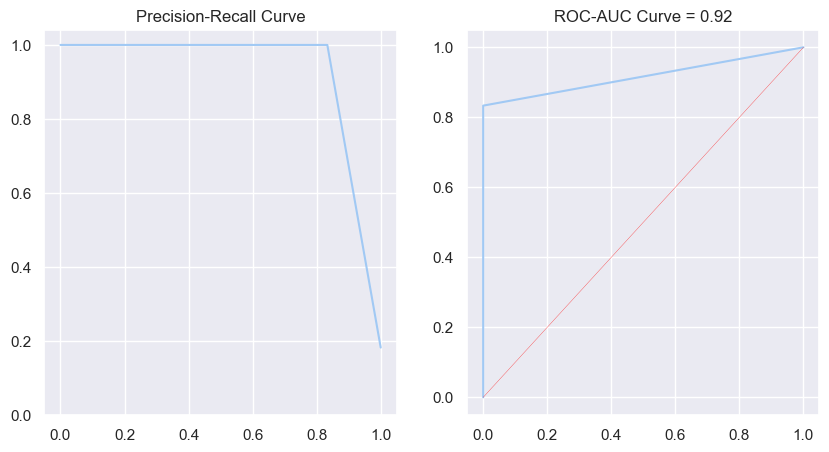

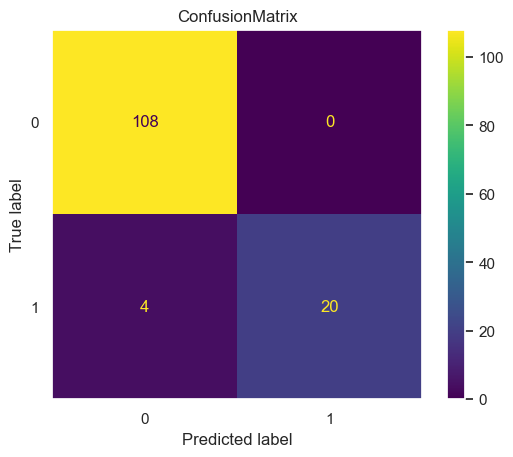

In [11]:
svc = SVC(kernel='rbf').fit(X_train, y_train)
preds = svc.predict(X_test)

cm = confusion_matrix(y_test, preds)
CM = ConfusionMatrixDisplay(cm)
fpr, tpr, thresholds = roc_curve(y_test, preds)
prec, rec, thresholds = precision_recall_curve(y_test, preds)

print(classification_report(y_test, preds))

plt.rcParams["axes.grid"] = True
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(rec, prec)
plt.yticks(np.arange(0,1.1, .2))
plt.title('Precision-Recall Curve')

plt.subplot(122)
plt.plot(fpr, tpr)
sns.lineplot(x=[0,1],y=[0,1], color='red', linewidth=0.2)
plt.title(f'ROC-AUC Curve = {round(roc_auc_score(y_test, preds), 2)}')

CM.plot()
plt.title('ConfusionMatrix')
plt.grid(False)
plt.show()

In [12]:
#false negative is TEST-PREDS == 1, false positive is TEST-PREDS == -1
#true positive or true negative will be TEST-PREDS == 0
false = y_test - preds != 0
false_index = test_index[false]
false_index

array([34, 51, 64, 66])

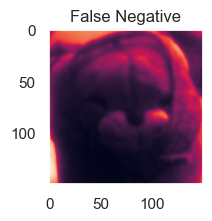

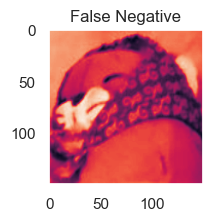

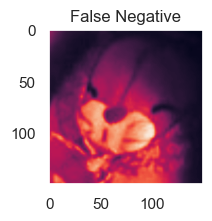

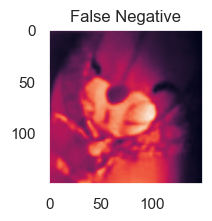

In [13]:
plt.rcParams['axes.grid'] = False
for i in false_index:
    plt.figure(figsize=(2,2))
    if i < len(positive_tusya) - 1:
        plt.imshow(positive_tusya[i])
        plt.title('False Negative')
        plt.show()
    else:
        plt.imshow(negative_tusya[i])
        plt.title('False Positive')
        plt.show()

In [14]:
svc = SVC(kernel='rbf').fit(X, y)

## Object Recognition Algorithm

* The window with the size `MIN_SIZE` slides over the picture creating HOG features. After each full scan, the window size increases. Increasing the window size allows us to recognize Tusya of any size.
* Due to the fact our window is increasing its own size after each image scanning we must to resize each window image to `MIN SIZE` so that our model can work.
* Our model gets HOG features and gives a prediction of whether there is Tusya in the current window.
* If it's there, then we flag the position of current window in the mask array.

<img src='https://github.com/ssensse/ds_labs/blob/main/Tusya_ObjectRecognition/window_slide_illustration.jpg?raw=true' width=800>

Our functions below have too many parameters for now. We'll analyse them later and find optimal values for them.

In [15]:
def get_heatmap(image, min_window_size, step, number_of_window_sizes):

    mask = np.zeros(image.shape[:2])
    hIm, wIm = image.shape[:2]
    
    # Simple calculations below find maximum window size preserving proportions of rectangle
    max_win_height = min_window_size[1] * (hIm // min_window_size[1])
    max_win_width = int(max_win_height * (min_window_size[0] / min_window_size[1]))
    # Window size is increasing in geometric progression
    width_range = np.int64(
        np.geomspace(min_window_size[0], max_win_height, number_of_window_sizes))
    height_range = np.int64(
        np.geomspace(min_window_size[1], max_win_height, number_of_window_sizes))

    # After each scanning window increases
    for win_width, win_height in zip(width_range, height_range):
        # w1 is the left coordinate of window width in the image, w2 is the right one
        for w1, w2 in zip(range(0, wIm - win_width, step), range(win_width, wIm, step)):
            # h1 is the top coordinate, h2 is the bottom
            for h1, h2 in zip(
                range(0, hIm - win_height, step), range(win_height, hIm, step)):

                window = image[h1:h2, w1:w2]
                resized_window = cv2.resize(window, MIN_SIZE)
                features_of_window = get_hog(resized_window)
                
                prediction = svc.predict([features_of_window])
                if prediction == 1:
                    mask[h1:h2, w1:w2] += 10
                    
    if mask.max() != 0:
        mask = mask / mask.max() * 255
    
    return np.int32(mask)

In [16]:
def filter_mask(mask, threshold, mode):
    mask_ = mask.copy()
    if mode == 'bool':
        mask_[mask_ > 0] = 1
        return mask_
    else:
        mask_[mask_ < threshold] = 0
    return mask_

In [17]:
def set_rectangles(image, mask, min_window_size):
    image_ = image.copy()
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8),1,2)[-2:]
    for c in contours:
        if cv2.contourArea(c) < min_window_size[0] * min_window_size[1]:
            continue
        (x,y,w,h) = cv2.boundingRect(c)
        image_ = cv2.rectangle(image_, (x,y),(x+w,y+h),(100,0,200), 10)
    return image_

In [18]:
def transform_image(image, max_image_length=None, resize_image=False, transform_channel=False):
    hIm, wIm = image.shape[:2]
    
    if resize_image:
        ratio_h = hIm / wIm
        while max(hIm, wIm) > max_image_length:
            hIm = hIm - ratio_h * 10
            wIm = wIm - 10
        image = cv2.resize(image, np.int32([wIm, hIm]))
        
    
    if transform_channel:
        if image.dtype == np.float32:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        elif image.dtype == np.uint8:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return image

## Parameter Analysis

In [19]:
def detect_tusya(images, threshold = 200, min_window_size = (100, 100), 
                 step = 25, number_of_window_sizes = 15, mode = 'bool',
                 max_image_length = 1000, visualize=False):
    
    images_ = images.copy()
    
    images_ = [transform_image(img, resize_image=True, max_image_length=max_image_length) for img in images_]
    
    results = {'images': [],
               'filtered_masks': [],
               'masks': []}
    
    for img in images_:
        
        example = transform_image(img, transform_channel=True)
        mask = get_heatmap(example, min_window_size, step, number_of_window_sizes)
        mask_fltr = filter_mask(mask, threshold, mode)
        rectangled = set_rectangles(img, mask_fltr, min_window_size)
        
        results['images'].append(rectangled)
        results['filtered_masks'].append(mask_fltr)
        results['masks'].append(mask)
        
        if visualize:
            fig, axs = plt.subplots(1, 3, figsize=(10, 4))
            axs = axs.flatten()
            for i, key in enumerate([rectangled, mask_fltr, mask]):
                axs[i].imshow(key)
            plt.show()
            
    return results

We have the following parameters:
* `mode` ("heatmap", "bool"). 
    - Heatmap can show us the area where the model predicted Tusya's presence the most.
    - For bool mode we don't need to find the most predicted area but we need every window where our model found Tusya.
* `threshold` (0 - 255). If we use "heatmap" mode we need to keep the most predicted area and hide the less one.
* `min_window_size`. The min size of window we start with. It highly affect the detecting time. In addition to this, too big `min_window_size` can miss small Tusya on an image. 
* `step`. It determines how far the next window would be from the current. If step is too big, we can miss small Tusya on an image. If it's too small then we highly increasing detecting time.
* `number_of_window_sizes`. Our window is growing until it reaches the maximum possible size. This parameter stretches the growth process. This parameter depends on the `max_image_length` and `min_window_size`.
* `max_image_length`. We must to resize the original image because it super highly increasing our detecting time. Moreover, if we have a very big image to work with, our HOG method have high chance to find objects which might be simial with Tusya.

In [20]:
paths = ['PositiveTusyaOriginal/IMG20240303174750.jpeg', 
         'PositiveTusyaOriginal/IMG20240303174404.jpeg',
         'PositiveTusyaOriginal/IMG20240303174311.jpeg',
         'PositiveTusyaOriginal/IMG20240303174218.jpeg',
         'C:/Users/79283/Desktop/Новая папка/IMG20231007002834.jpg',
         'C:/Users/79283/Desktop/Разное/Фотки/photo3.jpg',
         'C:/Users/79283/Desktop/Разное/cate1.jpg',
         'PositiveTusyaOriginal/photo_2024-03-06_00-22-2611.jpg']

images = [load_image(path) for path in paths]

### *Mode* parameter.

**mode = "bool"**

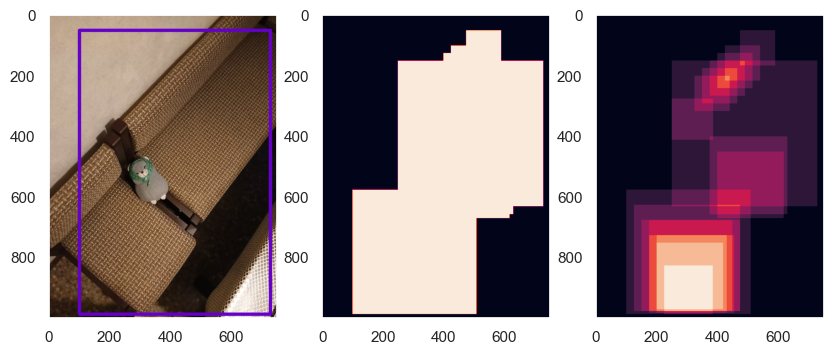

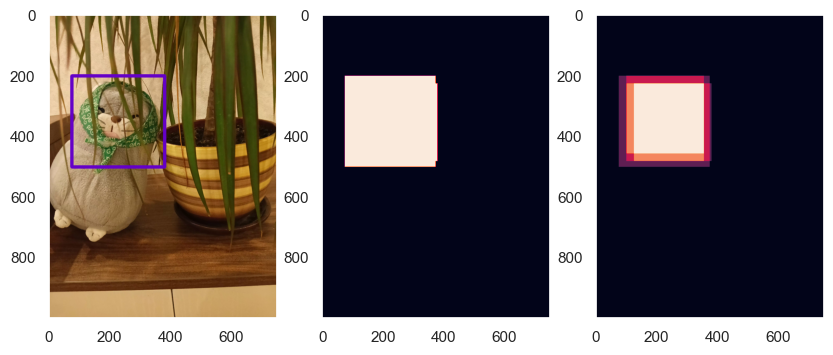

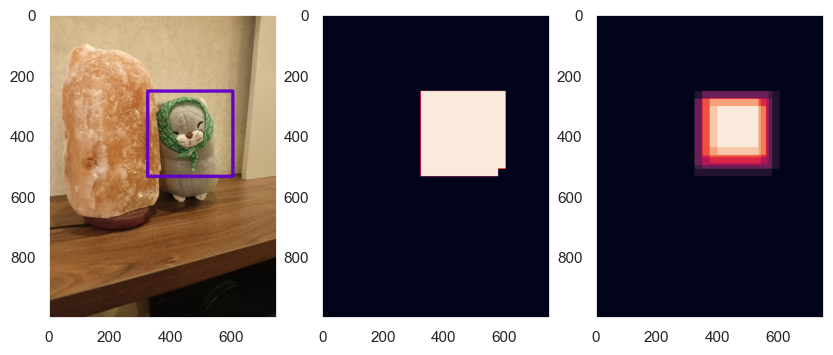

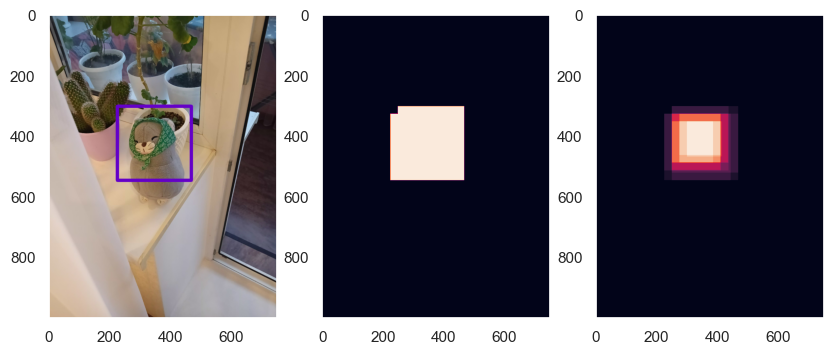

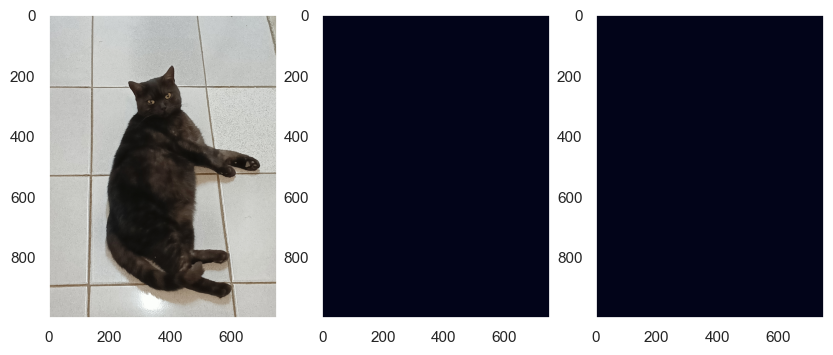

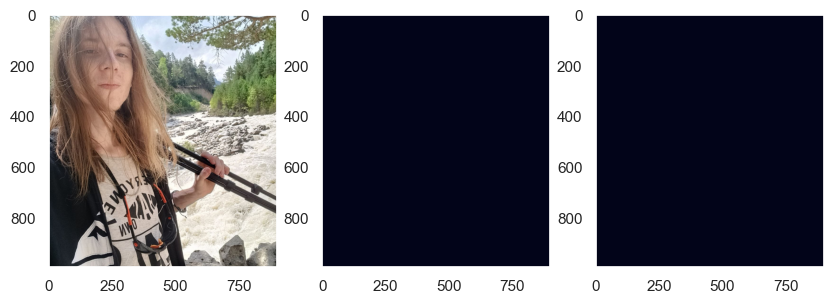

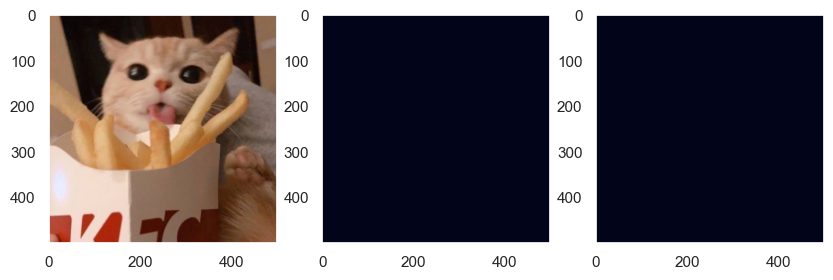

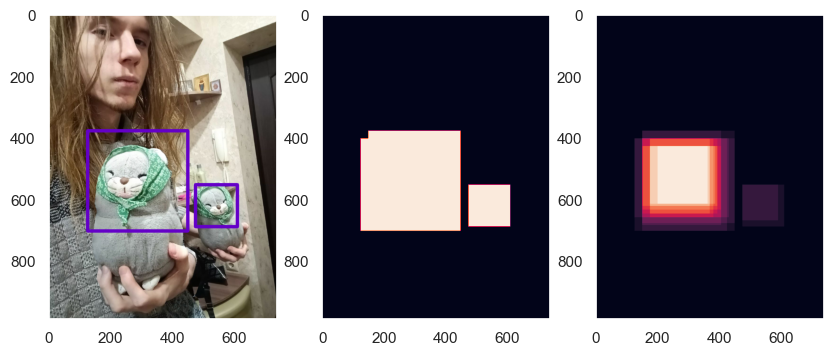

Mean detecting time: 34.721577286720276 s


In [21]:
start = time.time()
detect_tusya(images, mode='bool', min_window_size=(100,100), visualize=True)
print('Mean detecting time:', (time.time() - start) / len(images), 's')

**mode = "heatmap"**

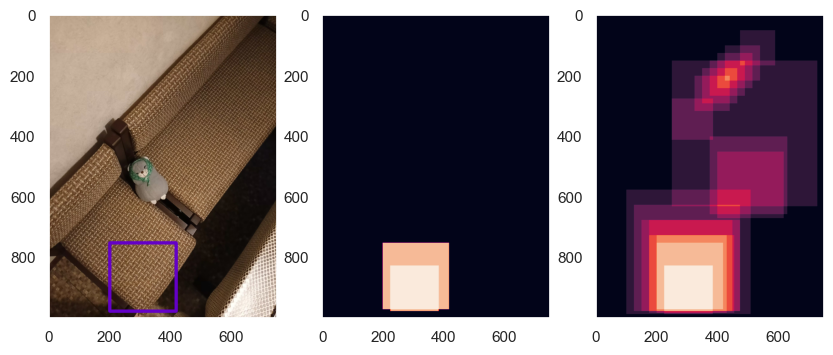

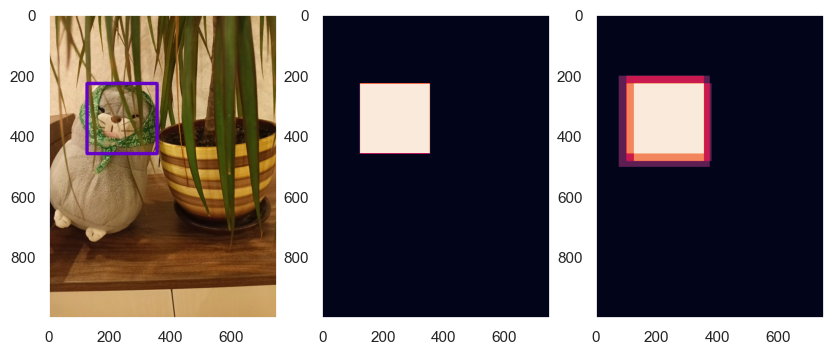

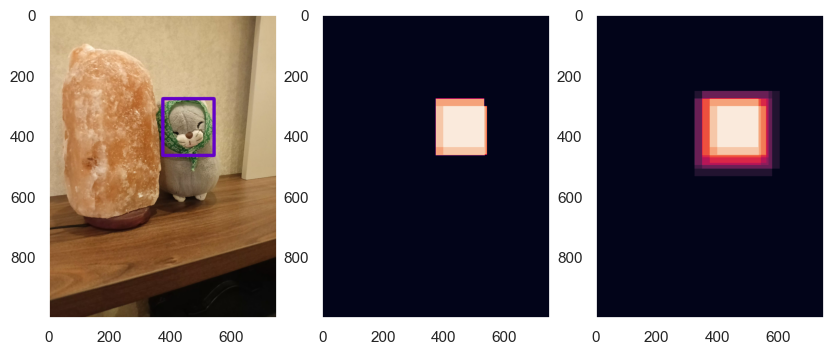

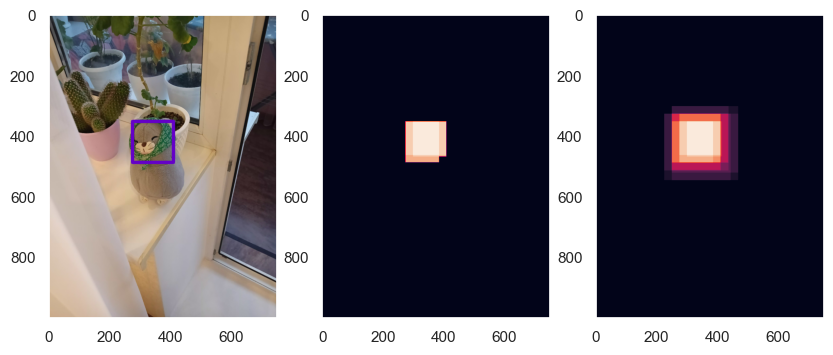

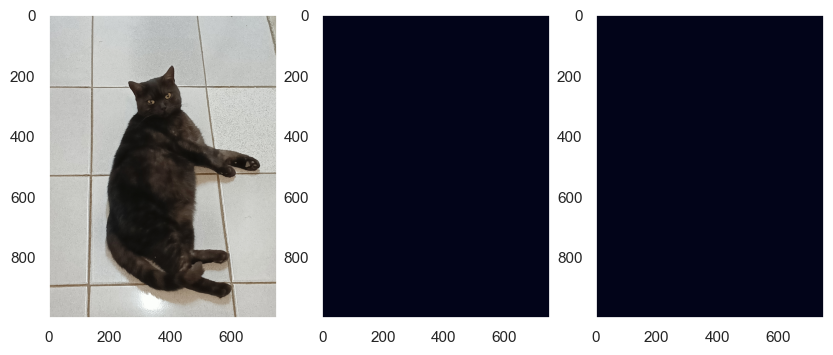

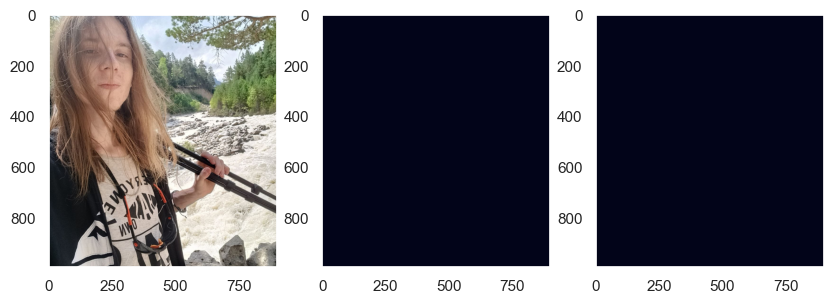

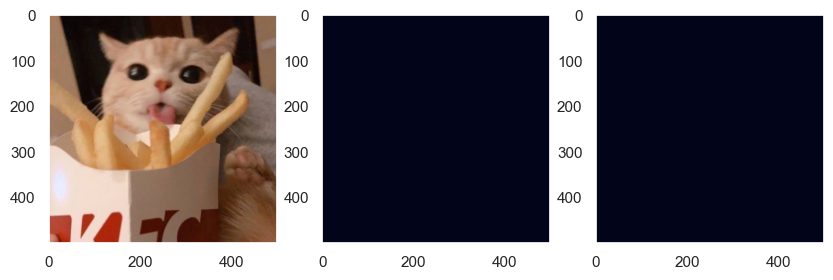

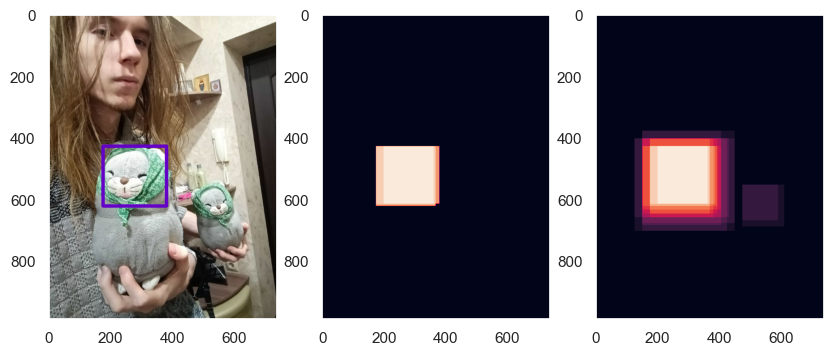

Mean detecting time: 37.79553669691086 s


In [22]:
start = time.time()
detect_tusya(images, mode='heatmap', visualize=True)
print('Mean detecting time:', (time.time() - start) / len(images), 's')

* As we can see, our heatmap works badly when we have two target objects on an image. This relates us to the calculation of mask. The larger Tusya is, the more it will accumulate positive predictions.
* On the other hand, heatmap mode works with `threshold` parameter which helps us to hide incorrect recognition.

I guess, choosing the right mode depends on your task. Anyway in my case, I'd better use bool mode.

### *min_window_size* parameter

Having smaller min_window_size gives our model better chances detecting a small Tusya on the image. But it takes significant amount of time. 

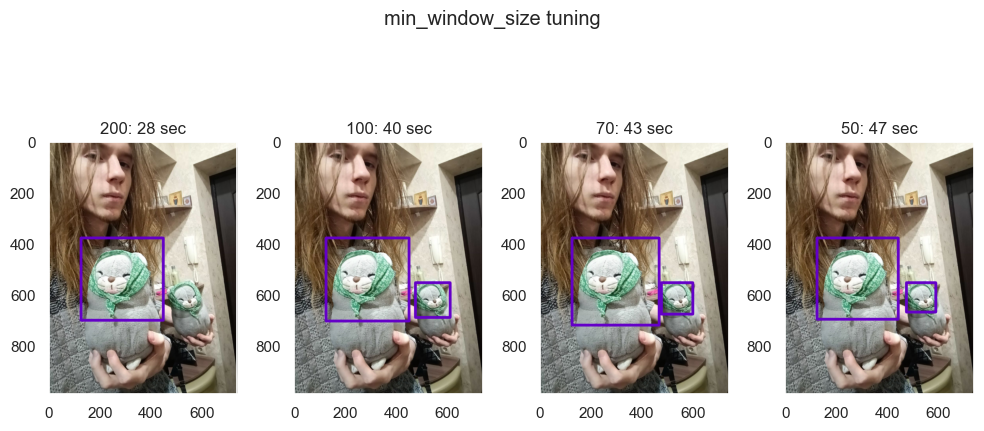

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(10,5))
for i, w_size in enumerate([200, 100, 70, 50]):
    start = time.time()
    res = detect_tusya(images[-1:], min_window_size=(w_size, w_size))
    t = round(time.time() - start)
    axs[i].imshow(res['images'][0])
    axs[i].set_title(f'{w_size}: {t} sec')
plt.suptitle('min_window_size tuning')
plt.tight_layout()
plt.show()

### *step* parameter

Let's set `min_window_size = (100,100)`

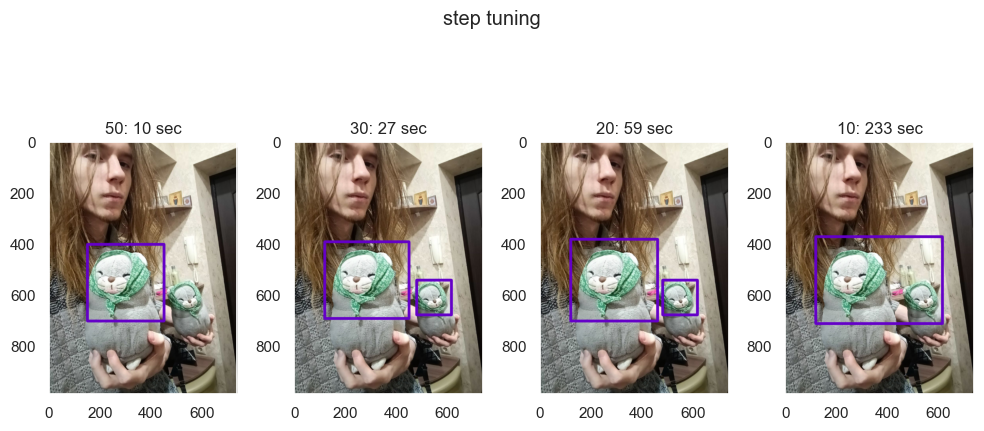

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(10,5))
for i, step in enumerate([50, 30, 20, 10]):
    start = time.time()
    res = detect_tusya(images[-1:], min_window_size = (100,100), step=step)
    t = round(time.time() - start)
    axs[i].imshow(res['images'][0])
    axs[i].set_title(f'{step}: {t} sec')
plt.suptitle('step tuning')
plt.tight_layout()
plt.show()

As we can see the smaller Tusya was skipped with big step.

### *number_of_window_sizes* parameter

In [25]:
params = {'min_window_size': (100,100),
          'step': 25}

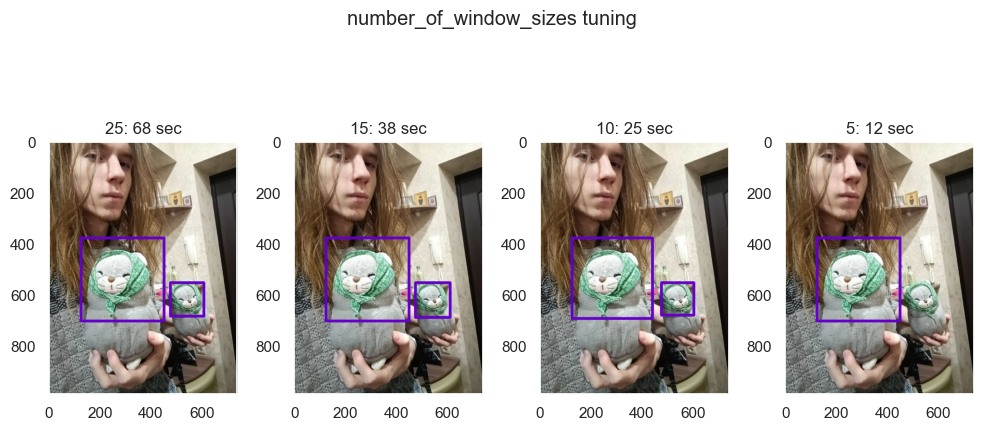

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(10,5))
for i, n in enumerate([25, 15, 10, 5]):
    start = time.time()
    res = detect_tusya(images[-1:], number_of_window_sizes=n, **params)
    t = round(time.time() - start)
    axs[i].imshow(res['images'][0])
    axs[i].set_title(f'{n}: {t} sec')
plt.suptitle('number_of_window_sizes tuning')
plt.tight_layout()
plt.show()

### *max_image_length* parameter

In [27]:
params = {'number_of_window_sizes': 10,
          'min_window_size': (100,100),
          'step': 25}

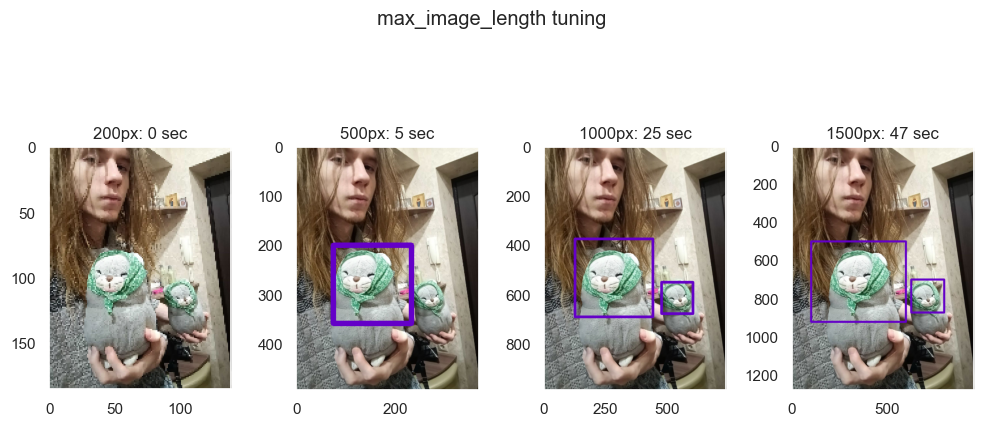

In [28]:
fig, axs = plt.subplots(1, 4, figsize=(10,5))
for i, l in enumerate([200, 500, 1000, 1500]):
    start = time.time()
    res = detect_tusya(images[-1:], max_image_length=l, **params)
    t = round(time.time() - start)
    axs[i].imshow(res['images'][0])
    axs[i].set_title(f'{l}px: {t} sec')
plt.suptitle('max_image_length tuning')
plt.tight_layout()
plt.show()

`max_image_length = 500` gives us very fast detection time. 

As we can see on the first image, smaller Tusya was skipped. It's obvious depends on `min_window_size`, smaller Tusya is much smaller than min_window.

Let's tune *min_window_size* and *step*.

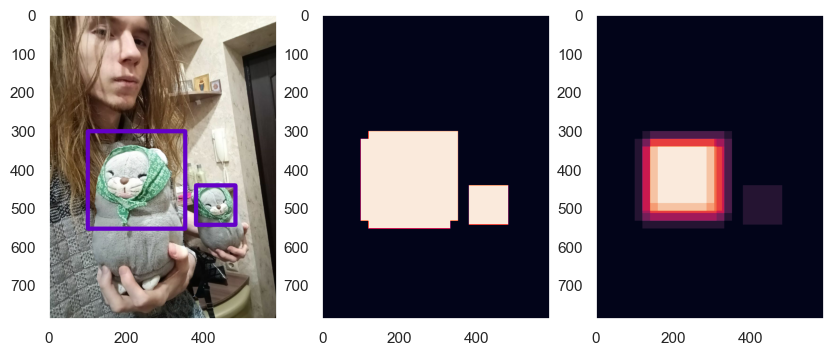

26 sec


In [29]:
params = {
    'mode': 'bool',
    'max_image_length': 800,
    'min_window_size': (80, 80), 
    'step': 20,
    'number_of_window_sizes': 10
}
start = time.time()
detect_tusya(images[-1:], visualize=True, **params)
    
print(round(time.time() - start), 'sec')

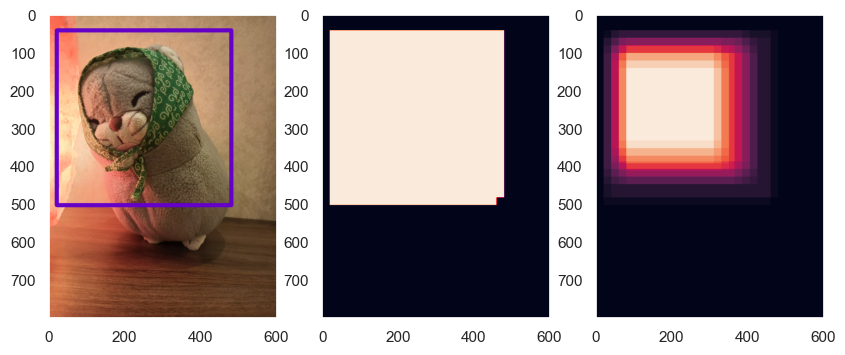

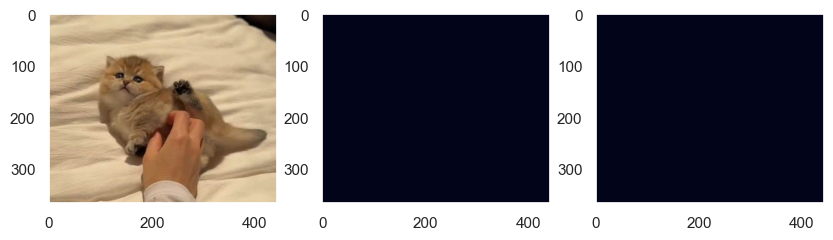

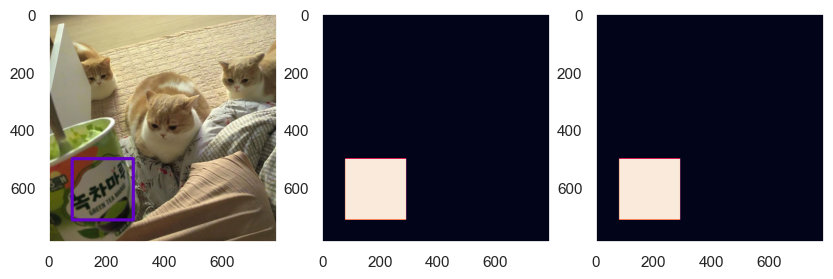

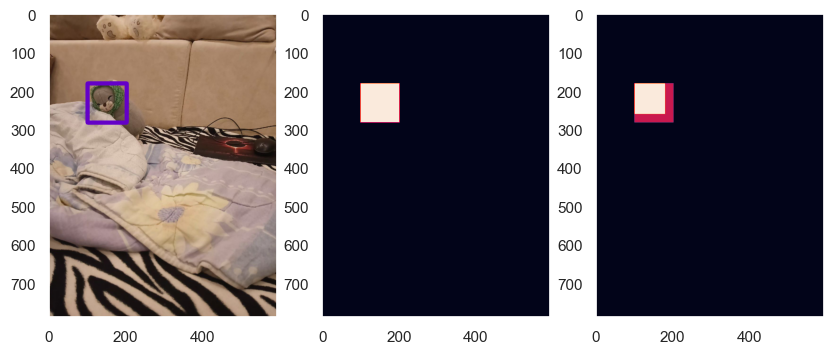

Mean detecting time: 25.671995282173157 s


In [30]:
paths = ['PositiveTusyaOriginal/IMG20240303174343.jpeg',
         'C:/Users/79283/Desktop/Разное/cate2.jpg',
         'C:/Users/79283/Desktop/Разное/cate3.jpg',
         'C:/Users/79283/Desktop/Разное/tusya2.jpg']
start = time.time()
images = [load_image(path) for path in paths]
_ = detect_tusya(images,
        visualize=True,
        **params)

print('Mean detecting time:', (time.time() - start) / len(images), 's')

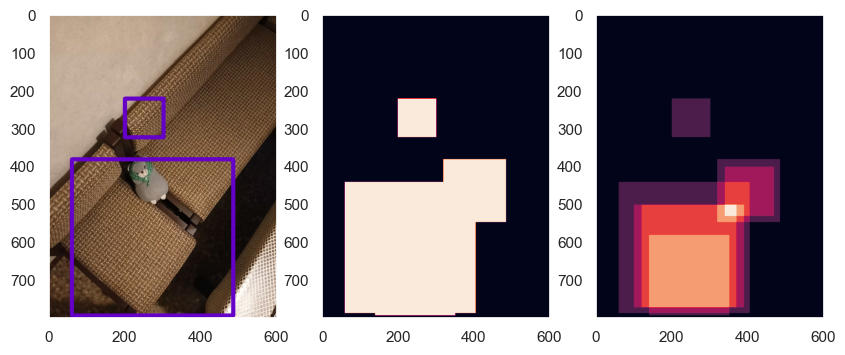

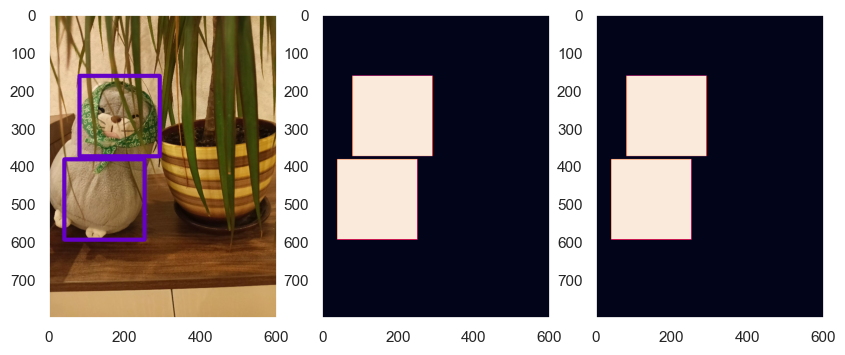

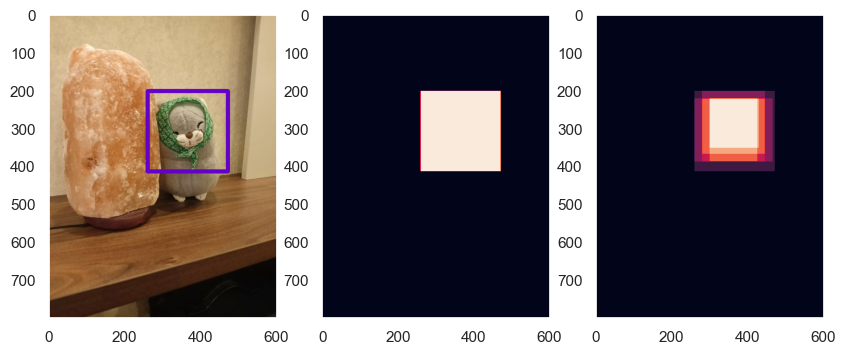

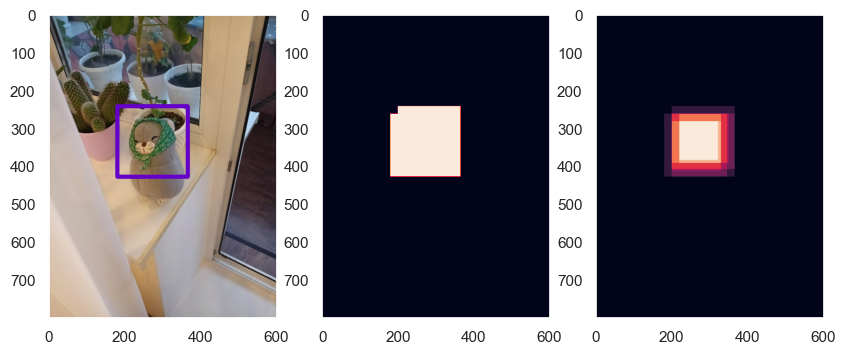

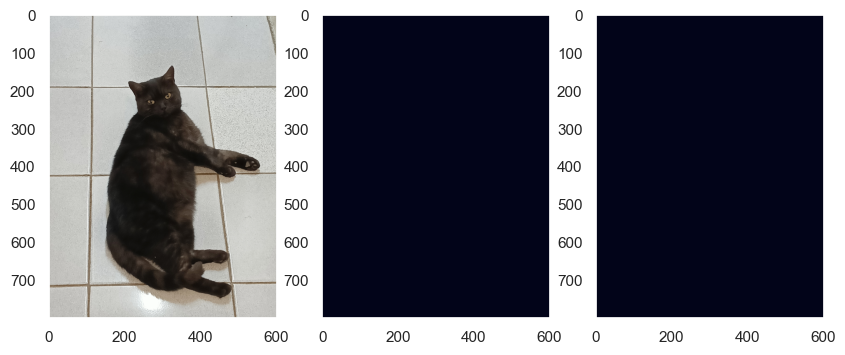

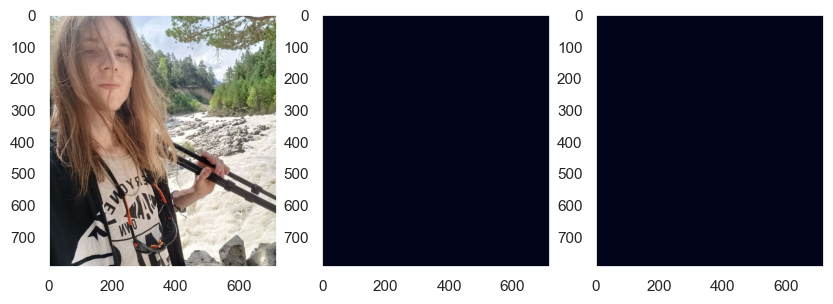

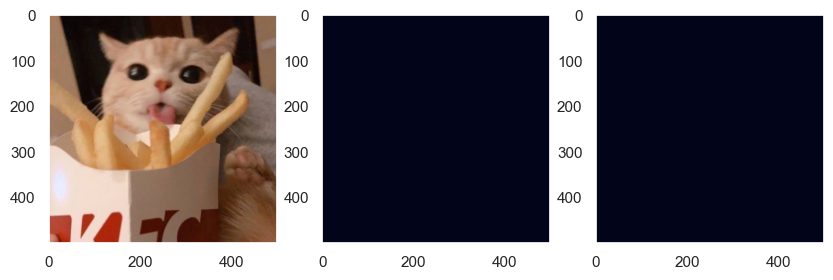

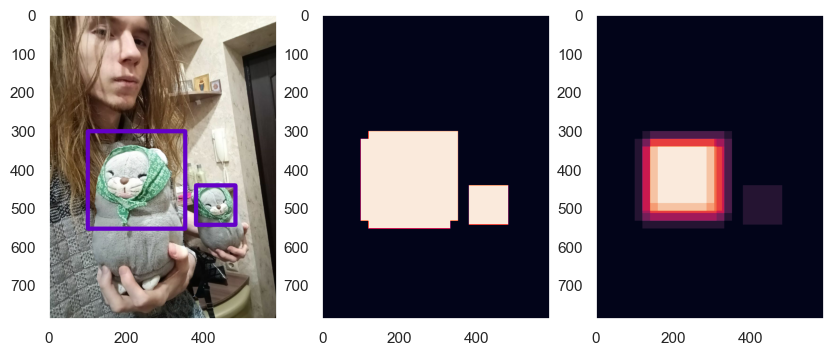

Mean detecting time: 26.62956863641739 s


In [31]:
paths = ['PositiveTusyaOriginal/IMG20240303174750.jpeg', 
         'PositiveTusyaOriginal/IMG20240303174404.jpeg',
         'PositiveTusyaOriginal/IMG20240303174311.jpeg',
         'PositiveTusyaOriginal/IMG20240303174218.jpeg',
         'C:/Users/79283/Desktop/Новая папка/IMG20231007002834.jpg',
         'C:/Users/79283/Desktop/Разное/Фотки/photo3.jpg',
         'C:/Users/79283/Desktop/Разное/cate1.jpg',
         'PositiveTusyaOriginal/photo_2024-03-06_00-22-2611.jpg']
start = time.time()
images = [load_image(path) for path in paths]
_ = detect_tusya(images,
        visualize=True,
        **params)

print('Mean detecting time:', (time.time() - start) / len(images), 's')